In [ ]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

<module 'leukopy_lib' from '/content/drive/MyDrive/Leukopy/leukopy_lib.py'>

In [ ]:
## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  8 14:28:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Need to copy all the files on the local computer

!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes 
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

In [ ]:
def reload_save():
  !cp -r "/content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave.zip" .
  !unzip fullsave.zip

  model = tf.keras.models.load_model(filepath = '/content/fullsave')
  return model

In [ ]:
######################################################### Quelques statistiques #################################################################

In [ ]:
df_train.head()

,img_path,cell_type,label,label_2,label_3
0,/content/main_dataset/training_set/MO_679959.jpg,training_set,MO,MO,MO
1,/content/main_dataset/training_set/EO_500571.jpg,training_set,EO,EO,EO
2,/content/main_dataset/training_set/EO_473251.jpg,training_set,EO,EO,EO
3,/content/main_dataset/training_set/BA_636660.jpg,training_set,BA,BA,BA
4,/content/main_dataset/training_set/BA_260100.jpg,training_set,BA,BA,BA


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12778 entries, 0 to 12777
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   12778 non-null  object
 1   cell_type  12778 non-null  object
 2   label      12778 non-null  object
 3   label_2    12778 non-null  object
 4   label_3    12778 non-null  object
dtypes: object(5)
memory usage: 499.3+ KB


In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   1742 non-null   object
 1   cell_type  1742 non-null   object
 2   label      1742 non-null   object
 3   label_2    1742 non-null   object
 4   label_3    1742 non-null   object
dtypes: object(5)
memory usage: 68.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   2561 non-null   object
 1   cell_type  2561 non-null   object
 2   label      2561 non-null   object
 3   label_2    2561 non-null   object
 4   label_3    2561 non-null   object
dtypes: object(5)
memory usage: 100.2+ KB


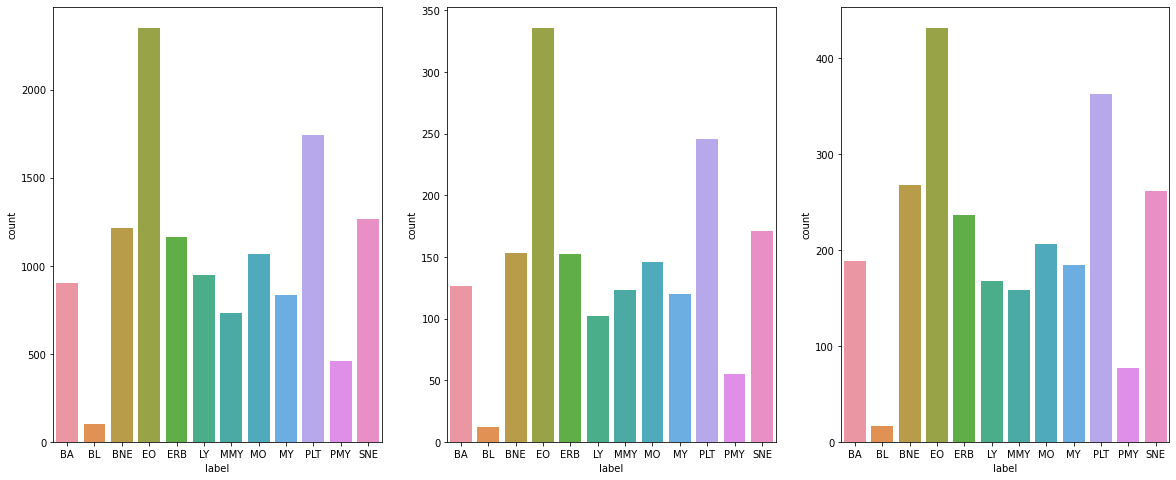

In [ ]:
import seaborn as sns
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,8))

sns.countplot(x = "label", data = df_train.sort_values(by = "label"), ax = ax1)
sns.countplot(x = "label", data = df_valid.sort_values(by = "label"),  ax = ax2)
sns.countplot(x = "label", data = df_test.sort_values(by = "label"),  ax = ax3)

In [ ]:
#### Remarques : 
# Fort déséquilibre entre la population de chaque classe. Il va falloir équilibrer. 3 pistes :
# - BalancedBatchGenerator de imblearn.keras (mais bug lors de l'import de la fonction)
# - https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
# - Augmentation de données pour équilibrer + production de nouveaux dataframes en ajoutant les images créées
## => L'option 3 est sans doute la meilleure si on veut appliquer des transformations aux BL (ImageDataGenerator ne leur fait pas grand chose...)

In [ ]:
######################################################### Génération d'images #################################################################

In [ ]:
## Preprocessing
batch_size = 64
img_height  = 300
img_width = 300

# EfficientNet normalizes itself the pictures. Data augmentation : rotation, zoom, brightness => only on training set
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True, 
                                     zoom_range = 0.5, 
                                     brightness_range = [0.2,1.8])
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)
                                                   #shuffle = True, 
                                                   #save_to_dir = '/content/datageneration', 
                                                   #save_prefix = 'gen_',
                                                   #save_format = 'png')

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

Found 12778 validated image filenames belonging to 12 classes.
Found 1742 validated image filenames belonging to 12 classes.
Found 2561 validated image filenames belonging to 12 classes.


In [ ]:
########################################################## Data-Generation analysis #############################################################

In [ ]:
shutil.rmtree('/content/datageneration')
!mkdir '/content/datageneration'

In [ ]:
shutil.rmtree('/content/datageneration')

In [ ]:
def make_datagen(data, create = True, batch_number = 1):
  
  if create == True :
    !mkdir '/content/datageneration'
  else:
    shutil.rmtree('/content/datageneration')
    !mkdir '/content/datageneration'

  # Generate augmented pictures :
  for i in range(batch_number):
    next(data)

  # List and count all pictures :
  aug_file_nm = os.listdir('/content/datageneration')
  number_files = len(aug_file_nm)
  print("Number of new images generated: {}".format(number_files))

  # Plot augmented pictures :
  number_lines = np.ceil(number_files/8)

  plt.figure(figsize = (32,number_lines*4))
  for i in range (number_files):
    path_img = aug_file_nm[i]
    plt.subplot(number_lines,8,i+1)
    plt.imshow(plt.imread('/content/datageneration/'+path_img))

  return


In [ ]:
make_datagen(training_set, create = False, batch_number = 5)

In [ ]:
#for i in range(3):
#    next(training_set)

#aug_file_nm = os.listdir('/content/datageneration')
#number_files = len(aug_file_nm)
#print("Number of new images generated: {}".format(number_files))

Number of new images generated: 192


In [ ]:
dir(training_set)

In [ ]:
#plt.figure(figsize = (90,30))

#for i in range (192):
#  path_img = aug_file_nm[i]
#  plt.subplot(24,8,i+1)
#  plt.imshow(plt.imread('/content/datageneration/'+path_img))

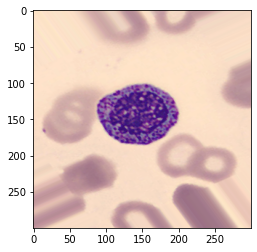

In [ ]:
#plt.imshow(plt.imread('/content/datageneration/gen__4465_5284350.png'))

In [ ]:
# Labels/Index connection :
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

label_map = training_set.class_indices

Train : {'BA': 0, 'BL': 1, 'BNE': 2, 'EO': 3, 'ERB': 4, 'LY': 5, 'MMY': 6, 'MO': 7, 'MY': 8, 'PLT': 9, 'PMY': 10, 'SNE': 11}
Valid : {'BA': 0, 'BL': 1, 'BNE': 2, 'EO': 3, 'ERB': 4, 'LY': 5, 'MMY': 6, 'MO': 7, 'MY': 8, 'PLT': 9, 'PMY': 10, 'SNE': 11}
Test  : {'BA': 0, 'BL': 1, 'BNE': 2, 'EO': 3, 'ERB': 4, 'LY': 5, 'MMY': 6, 'MO': 7, 'MY': 8, 'PLT': 9, 'PMY': 10, 'SNE': 11}


In [ ]:
########################################################### Imbalanced classes strategy #######################################################
## Use class_weight to penalize errors committed on low-population classes

## Other option : make data augmentation before training the model in order to have an equal number of pictures of each class.

In [ ]:
## Test - class_weight computation (method 1)
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} 
class_weights

{0: 2.604651162790698,
 1: 23.287128712871286,
 2: 1.9405940594059405,
 3: 1.0,
 4: 2.0240963855421685,
 5: 2.4862579281183934,
 6: 3.204359673024523,
 7: 2.202247191011236,
 8: 2.823529411764706,
 9: 1.3493975903614457,
 10: 5.101952277657267,
 11: 1.8622327790973872}

In [ ]:
## Test - class_weight computation (method 2)

class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(training_set.classes), 
                                     y = training_set.classes)
class_weights = dict(enumerate(class_weights))
class_weights


## Les poids sont différents de ceux obtenus avec la méthode 1, mais il y a une relation de proportionnalité (a = 2.20879) entre les deux
## ensembles de poids.

{0: 1.17921742340347,
 1: 10.542904290429043,
 2: 0.8785753575357536,
 3: 0.45273526077097503,
 4: 0.9163798049340218,
 5: 1.1256166314305849,
 6: 1.4507266121707538,
 7: 0.9970349563046192,
 8: 1.2783113245298119,
 9: 0.6109198699560145,
 10: 2.309833694866233,
 11: 0.8430984428609132}

In [ ]:
## Test - class_weight computation (method 3)   weight = 1/class_pop * total_pop/2
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

counter = Counter(training_set.classes)                          
class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()} 
class_weights

{0: 7.075304540420819,
 1: 63.257425742574256,
 2: 5.271452145214521,
 3: 2.7164115646258504,
 4: 5.498278829604131,
 5: 6.75369978858351,
 6: 8.704359673024523,
 7: 5.9822097378277155,
 8: 7.669867947178871,
 9: 3.665519219736087,
 10: 13.859002169197398,
 11: 5.058590657165479}

In [ ]:
## Function : compute weights according to a chosen method 
# default : 3, preserve the order of magnitude of the loss function
# optimizer = Adam is unaffected by a scaling change, but other optimizers can fail

def compute_weights(method = 3):

  if method == 1:
    counter = Counter(training_set.classes)     
    class_weights = {class_id : float(max(counter.values()))/num_images for class_id, num_images in counter.items()} 
    return class_weights

  if method == 2:
    class_weights = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(training_set.classes),
                                         y = training_set.classes)
    class_weights = dict(enumerate(class_weights))
    return class_weights

  counter = Counter(training_set.classes)                          
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()} 
  return class_weights

In [ ]:
################################################ Model : Transfer Learning from EfficientNet B3  #######################################################

In [ ]:
## Modèle : EfficientNetB3, transfer learning, Sequential Model

def build_model(dropout_rate = 0.2): 
  base_model = EfficientNetB3(include_top = False,
                              weights = 'imagenet',
                              input_shape = (300,300,3))
  # Freeze EfficientNet
  base_model.trainable = False
  
  # Classification layers
#  model = Sequential()
#  model.add(base_model)
#  model.add(layers.GlobalAveragePooling2D())
#  model.add(layers.Dense(units = 1280, activation = 'relu'))
#  model.add(layers.Dense(units = 640, activation = 'relu'))
#  model.add(layers.Dropout(rate = 0.2))
#  model.add(layers.Dense(units = 11, activation = 'softmax'))

  model = Sequential()
  model.add(base_model, training = False)
  model.add(layers.GlobalAveragePooling2D(name = "output_pooling"))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(rate = dropout_rate))
  model.add(layers.Dense(units = 12, activation = 'softmax'))

  # Compile
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
  model.compile(optimizer = optimizer, 
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])

  return model

In [ ]:
## Modèle : EfficientNetB3, transfer learning, Functional API

def build_model_funct(dropout_rate = 0.2):

  # Freeze EfficientNet
  base_model = EfficientNetB3(include_top = False,
                              input_shape = (300,300,3),
                              weights = 'imagenet')
  base_model.trainable = False

  # Model (Functional API)
  #inputs = tf.keras.Input(shape = (300,300,3))
  #x = base_model(inputs, training = False)   # BatchNormalization layers run in 'inference mode'.
  #x = layers.GlobalAveragePooling2D(name = "output_pooling")(x)
  #x = layers.Dropout(rate = dropout_rate, name = "output_dropout_1")(x)
  #outputs = layers.Dense(units = 12, activation = 'softmax', name = "dense_1")(x)
  #model = tf.keras.Model(inputs, outputs)

  # Model + Dense Layer "dense_2" : units = 1536 (size of the output of enetb3)
  inputs = tf.keras.Input(shape = (300,300,3))
  x = base_model(inputs, training = False)   # BatchNormalization layers run in 'inference mode'.
  x = layers.GlobalAveragePooling2D(name = "output_pooling")(x)
  x = layers.Dropout(rate = dropout_rate, name = "output_dropout_1")(x)
  x = layers.Dense(units = 1536, activation = 'relu', name = "dense_3")(x)
  x = layers.Dense(units = 384, activation = 'relu', name = "dense_2")(x)
  #x = layers.Dense(units = 128, activation = 'relu', name = "dense_2")(x)
  outputs = layers.Dense(units = 12, activation = 'softmax', name = "dense_1")(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
  model.compile(optimizer = optimizer, 
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

In [ ]:
# Training function

def training_model(model, training_set, validation_set = None, epochs = 1, weights_method = 3, reload = False):

  ## Load a saved model
  if reload == True :
    model = tf.keras.models.load_model(filepath = '/content/fullsave')

    #%cp -r '/content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave.zip' '/content'
    #!unzip fullsave.zip
    #model = tensorflow.keras.models.load_model(filepath = '/content/fullsave')

  ## Callbacks :
  TON = TerminateOnNaN()
  save_model = ModelCheckpoint(filepath = '/content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave',
                               monitor = 'val_loss',
                               save_best_only = True,
                               save_weights_only = False,
                               save_freq = 'epoch')
  
  control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.1,
                                 patience = 3,
                                 verbose = 1,
                                 mode = 'min', 
                                 min_lr = 1e-5)
  
  early_stopping = EarlyStopping(monitor = "val_loss",
                                 patience = 5,
                                 mode = 'min',
                                 restore_best_weights = True)

  callbacks_list = [TON, save_model, control_lr, early_stopping]
                    
  ## Compute weights :
  class_weights = compute_weights(method = weights_method)

  ## Training :
  history = model.fit(x = training_set, 
                      epochs = epochs,
                      callbacks = callbacks_list, 
                      validation_data = validation_set, 
                      class_weight = class_weights)

  ## Full model saving : model layers, weights, optimizer state :
  model.save(filepath = '/content/fullsave',
             overwrite = True, 
             include_optimizer = True, 
             save_traces = True)
  
  shutil.make_archive(base_name = '/content/fullsave', format = 'zip', root_dir = '/content/fullsave')
  %cp -r '/content/fullsave.zip' '/content/drive/MyDrive/Leukopy/EffNetB3_GPU_12'

  return model, history, class_weights

In [ ]:
## Fine-Tuning functions

def unfreeze_model(model, reload = False):

  # Load a saved model
  if reload == True :
    model = tf.keras.models.load_model(filepath = '/content/fullsave')

  # Unfreeze the top layers (7th block) while leaving BatchNorm layers frozen
  for layer in model.get_layer("efficientnetb3").layers[-31:-3]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
  model.compile(optimizer = optimizer, 
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model


def fine_tuning(model, training_set, validation_set = None, epochs = 1, reload = False):

  # Unfreeze block 7 layers (except BatchNormalization) and compile
  model = unfreeze_model(model, reload = reload)

  # Fine-tuning training
  model, history, class_weights = training_model(model, training_set, validation_set, epochs, reload = False)

  # Full model saving : model layers, weights, optimizer state :
  model.save(filepath = '/content/fullsave',
             overwrite = True, 
             include_optimizer = True, 
             save_traces = True)
  
  shutil.make_archive(base_name = '/content/fullsave', format = 'zip', root_dir = '/content/fullsave')
  %cp -r '/content/fullsave.zip' '/content/drive/MyDrive/Leukopy/EffNetB3_GPU_12'

  return model, history

In [ ]:
########################################################## Tests - Fonctionnement #########################################################

In [ ]:
# Build the model
model = build_model_funct()
# Summary - External layers :
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
output_pooling (GlobalAverag (None, 1536)              0         
_________________________________________________________________
output_dropout_1 (Dropout)   (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
dense_2 (Dense)              (None, 384)               590208    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                4620

In [ ]:
# Summary - EfficientNetB3 sublayers :
model.get_layer("efficientnetb3").summary()

In [ ]:
# Train the model
model, history, class_weights = training_model(model, 
                                               training_set = training_set, 
                                               validation_set = validation_set, 
                                               epochs = 50, 
                                               weights_method = 3, 
                                               reload = False)

Epoch 1/50
200/200 [==============================] - 302s 1s/step - loss: 10.9027 - accuracy: 0.4739 - val_loss: 1.0045 - val_accuracy: 0.6297


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 2/50
200/200 [==============================] - 295s 1s/step - loss: 5.8285 - accuracy: 0.6455 - val_loss: 1.1528 - val_accuracy: 0.5798
Epoch 3/50
200/200 [==============================] - 294s 1s/step - loss: 5.5438 - accuracy: 0.6629 - val_loss: 1.1610 - val_accuracy: 0.5563
Epoch 4/50
200/200 [==============================] - 294s 1s/step - loss: 5.3914 - accuracy: 0.6773 - val_loss: 0.9745 - val_accuracy: 0.6315


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 5/50
200/200 [==============================] - 296s 1s/step - loss: 5.1408 - accuracy: 0.6902 - val_loss: 0.8154 - val_accuracy: 0.6917


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 6/50
200/200 [==============================] - 297s 1s/step - loss: 4.8752 - accuracy: 0.6984 - val_loss: 0.7942 - val_accuracy: 0.7250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 7/50
200/200 [==============================] - 295s 1s/step - loss: 4.9484 - accuracy: 0.7002 - val_loss: 0.9055 - val_accuracy: 0.6538
Epoch 8/50
200/200 [==============================] - 295s 1s/step - loss: 5.1985 - accuracy: 0.6939 - val_loss: 0.7763 - val_accuracy: 0.7204


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 9/50
200/200 [==============================] - 298s 1s/step - loss: 5.2226 - accuracy: 0.6884 - val_loss: 1.0203 - val_accuracy: 0.6160
Epoch 10/50
200/200 [==============================] - 297s 1s/step - loss: 4.7763 - accuracy: 0.7087 - val_loss: 0.8147 - val_accuracy: 0.6952
Epoch 11/50
200/200 [==============================] - 294s 1s/step - loss: 5.1475 - accuracy: 0.6911 - val_loss: 0.8881 - val_accuracy: 0.6762

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
200/200 [==============================] - 294s 1s/step - loss: 4.4683 - accuracy: 0.7313 - val_loss: 0.7048 - val_accuracy: 0.7348


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 13/50
200/200 [==============================] - 295s 1s/step - loss: 4.1982 - accuracy: 0.7415 - val_loss: 0.6705 - val_accuracy: 0.7468


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 14/50
200/200 [==============================] - 296s 1s/step - loss: 4.1055 - accuracy: 0.7484 - val_loss: 0.6235 - val_accuracy: 0.7819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
Epoch 15/50
200/200 [==============================] - 295s 1s/step - loss: 4.1165 - accuracy: 0.7490 - val_loss: 0.6509 - val_accuracy: 0.7560
Epoch 16/50
200/200 [==============================] - 294s 1s/step - loss: 4.0932 - accuracy: 0.7478 - val_loss: 0.6426 - val_accuracy: 0.7658
Epoch 17/50
200/200 [==============================] - 297s 1s/step - loss: 4.1057 - accuracy: 0.7466 - val_loss: 0.6496 - val_accuracy: 0.7646

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 18/50
200/200 [==============================] - 295s 1s/step - loss: 4.0549 - accuracy: 0.7542 - val_loss: 0.6470 - val_accuracy: 0.7710
Epoch 19/50
200/200 [==============================] - 295s 1s/step - loss: 3.8942 - accuracy: 0.7615 - val_loss: 0.6404 - val_accuracy: 0.7727


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/fullsave/assets


In [ ]:
model.evaluate(testing_set)

41/41 [==============================] - 11s 258ms/step - loss: 0.5426 - accuracy: 0.8036


[0.5425623059272766, 0.803592324256897]

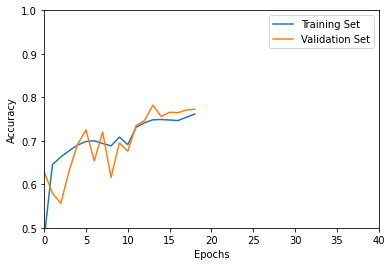

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,40])
plt.ylim([0.5,1])
plt.legend()
plt.show()

In [ ]:
# Continue training - Option 1 : (function reload_save)

model = reload_save()

In [ ]:
# Continue training - Option 2 : load_model + training

model, history, class_weights = training_model(model, 
                                               training_set = training_set, 
                                               validation_set = validation_set, 
                                               epochs = 4, 
                                               weights_method = 3, 
                                               reload = True)

Epoch 1/4
200/200 [==============================] - 324s 2s/step - loss: 3.9509 - accuracy: 0.7621 - val_loss: 0.5728 - val_accuracy: 0.7813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


Epoch 2/4
200/200 [==============================] - 314s 2s/step - loss: 3.8318 - accuracy: 0.7725 - val_loss: 0.5663 - val_accuracy: 0.7853


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


Epoch 3/4
200/200 [==============================] - 313s 2s/step - loss: 3.7974 - accuracy: 0.7727 - val_loss: 0.5691 - val_accuracy: 0.7916
Epoch 4/4
200/200 [==============================] - 314s 2s/step - loss: 3.8643 - accuracy: 0.7685 - val_loss: 0.5763 - val_accuracy: 0.7905


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/fullsave/assets


INFO:tensorflow:Assets written to: /content/fullsave/assets


In [ ]:
model.evaluate(testing_set)

41/41 [==============================] - 17s 404ms/step - loss: 0.5591 - accuracy: 0.7942


[0.559066891670227, 0.7942209839820862]

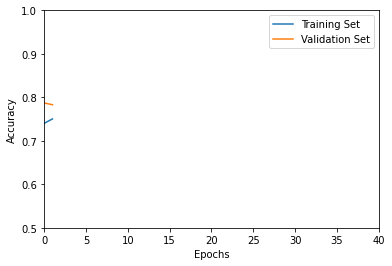

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,40])
plt.ylim([0.5,1])
plt.legend()
plt.show()

In [ ]:
# Fine_tuning

model, history = fine_tuning(model, 
                             training_set = training_set, 
                             validation_set = validation_set, 
                             epochs = 10, 
                             reload = False)

Epoch 1/2
200/200 [==============================] - 324s 2s/step - loss: 6.4377 - accuracy: 0.6694 - val_loss: 1.1399 - val_accuracy: 0.6579


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


Epoch 2/2
200/200 [==============================] - 313s 2s/step - loss: 6.2602 - accuracy: 0.6808 - val_loss: 1.1245 - val_accuracy: 0.6682


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/trainingsave/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EffNetB3_GPU_12/fullsave/assets


In [ ]:
############################################################### ANALYSIS (BROUILLON) ###############################################################

import matplotlib.cm as cm

### 1 -- Function : confusion matrix and classification report

def print_classification_report(testing_set):

  # Prediction on testing dataset
  labels = training_set.class_indices
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Compute and display the confusion matrix
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Classification report
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report : ")
  return display(df_report)

### 2 -- Function : dataframes for exploration
def exploration_dataframes(testing_set):

  # Prediction on testing dataset
  labels = training_set.class_indices
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # DF avec le résultat et le label de toutes les images du test :
  df_results = pd.DataFrame(data = {"real":testing_set.classes,
                                    "pred":y_pred,
                                    "img_path":df_test["img_path"]})
  
  # Tri des images : mal classé (df_false), bien classé (df_true):
  df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
  df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)

  return df_results, df_false, df_true

### 3 -- Grad-CAM
def get_img_array(img_path, size = (img_height, img_width)):
  img = keras.preprocessing.image.load_img(img_path, target_size = size)
  # 'array' : shape (img_height, img_width, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # Ajout d'une dimension pour transformer l'array en batch (1, height, width, 3)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
        pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 1):
  # Load the original image
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255*heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  superimposed_img.save(cam_path)

  # Display Grad CAM
  #display(Image(cam_path))
  #plt.imshow(plt.imread(cam_path))
  #plt.show()
  
  return cam_path

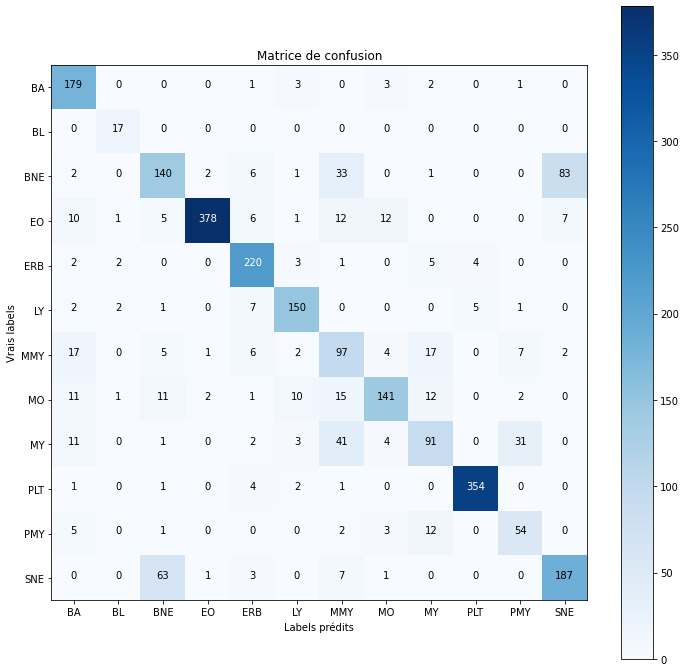

Classification Report : 


,precision,recall,f1-score,support
BA,0.745833,0.94709,0.834499,189
BL,0.73913,1,0.85,17
BNE,0.614035,0.522388,0.564516,268
EO,0.984375,0.875,0.926471,432
ERB,0.859375,0.92827,0.892495,237
LY,0.857143,0.892857,0.874636,168
MMY,0.464115,0.613924,0.52861,158
MO,0.839286,0.684466,0.754011,206
MY,0.65,0.494565,0.561728,184
PLT,0.975207,0.975207,0.975207,363


In [ ]:

print_classification_report(testing_set)